In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/Project_NeurosymbolicAI/6.Datasets/CLEVR_v1.0"
code_path = "/content/drive/MyDrive/Project_NeurosymbolicAI/7.Code/tbd-nets-encoder-main"
results_path = os.path.join(code_path, 'results')
data_path = os.path.join(code_path, 'data')
tbd_path = os.path.join(code_path, 'tbd')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install scipy==1.1.0

In [3]:
pip install numpy==1.13 matplotlib==2.0 h5py==2.7 pathlib2==2.3 scipy==0.19.1 jupyter==1.0.0 #pytorch==1.0.0 torchvision==0.2.1 

  Using cached numpy-1.13.0.zip (5.0 MB)
  Using cached matplotlib-2.0.0-cp37-cp37m-linux_x86_64.whl
  Using cached h5py-2.7.0-cp37-cp37m-linux_x86_64.whl
  Using cached pathlib2-2.3.0-py2.py3-none-any.whl (16 kB)
  Using cached scipy-0.19.1.tar.gz (14.1 MB)
  ERROR: Failed building wheel for numpy
  Running setup.py clean for numpy
  ERROR: Failed cleaning build dir for numpy
  ERROR: Failed building wheel for scipy
  Running setup.py clean for scipy
  ERROR: Failed cleaning build dir for scipy
Failed to build numpy scipy
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
    Running setup.py install for numpy ... error
  Rolling back uninstall of numpy
  Moving to /usr/bin/f2py
   from /tmp/pip-uninstall-61nz1fpq/f2py
  Moving to /usr/local/bin/f2py
   from /tmp/pip-uninstall-e5a5v9o2/f2py
  Moving to /usr/local/bin/f2py3
   from /tmp/pip-uninstall-e5a5v9o2/f2py3
  Moving to /usr/local

In [4]:
!pip install torch==1.5.0
!pip install torchvision==0.6.0

In [5]:
from pathlib import Path

import torch
import numpy as np
from scipy.misc import imresize
import matplotlib.pyplot as plt
%matplotlib inline

module_net = os.path.join(tbd_path,'module_net.py')
transformer = os.path.join(tbd_path,'transformer.py')

import sys
## use append to add path to google colab python path
sys.path.append(tbd_path)
from module_net import load_tbd_net

utils_path = os.path.join(code_path, 'utils')
sys.path.append(utils_path)
from clevr import load_vocab
#from utils.download_pretrained_models import download

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [7]:
model_path = os.path.join(code_path, 'models')
#vocab = load_vocab(Path('data/vocab.json'))
vocab = load_vocab(Path(os.path.join(data_path,'vocab.json')))

#model_path = Path('./models')
tbd_net_checkpoint = os.path.join(model_path, 'example-08.pt')
#if not (model_path / tbd_net_checkpoint).exists():
#    download(tbd_net_checkpoint)
    
#tbd_net = load_tbd_net(model_path / tbd_net_checkpoint, vocab)
#print('is cuda available: ', torch.cuda.is_available())
#tbd_net = load_tbd_net(tbd_net_checkpoint, vocab)
#tbd_net.to(device);

#tbd_net = TbDNet(vocab)
#tbd_net.load_state_dict(torch.load(str(checkpoint), map_location={'cuda:0': 'cpu'}))
#if torch.cuda.is_available():
#    tbd_net.cuda()

In [8]:
#tbd_net = load_tbd_net(model_path / tbd_net_checkpoint, vocab)
#print('is cuda available: ', torch.cuda.is_available())
#tbd_net = load_tbd_net(tbd_net_checkpoint, vocab)
#tbd_net.to(device);

from module_net import TbDNet
tbd_net = TbDNet(vocab,feature_dim=(1024, 14, 14))

#tbd_net.load_state_dict(tbd_net[‘state_dict’])

checkpoint = torch.load(tbd_net_checkpoint)
#print(checkpoint)
state_dict = checkpoint["state_dict"]
tbd_net.load_state_dict(state_dict)
#tbd_net.load_state_dict(torch.load(str(tbd_net_checkpoint)))


#tbd_net.load_state_dict(torch.load(str(tbd_net_checkpoint), map_location={'cuda:0': 'cpu'}))
if torch.cuda.is_available():
    tbd_net.cuda()

Comparison Module
Comparison Module
Comparison Module
Comparison Module
Comparison Module
Comparison Module
Comparison Module


Helper functions

In [9]:
def forward_input(module_name, in1, in2):
    ''' Send `in1` and `in2` through the `module_name` module. 
    
    Parameters
    ----------
    module_name : str
        The module to forward input through.
        
    in1 : torch.Tensor
        The first input.
        
    in2 : torch.Tensor
        The second input.
        
    Returns
    -------
    torch.Tensor
        The output of the operation `module_name` when given `in1` and `in2`.
    '''
    return tbd_net.function_modules[module_name](in1, in2)

def attn_tensor_to_np(attn):
    ''' Convenience function to take an input `Tensor` and convert to a NumPy array.
    
    Parameters
    ----------
    attn : torch.Tensor
        The attention mask `Tensor` to convert to a NumPy array.
        
    Returns
    -------
    numpy.ndarray
        An array of shape (r, c) containing the data from `attn`.
    '''
    return attn.detach().to('cpu').numpy().squeeze()

def display_helper(ax, attn, title='', interp='lanczos', alpha = 1.0):
    ''' Convenience function to plot an attention on a set of axes.
    
    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The set of axes on which to display the attention.
        
    attn : numpy.ndarray, shape (r, c)
        The attention mask to display.
        
    title : str, optional (default='')
        The title to display over the plot.
    
    interp : str, optional (default='lanczos')
        The type of interpolation to use. In our paper, we use lanczos interpolation
        for the smoothed images and nearest for the rest of our visualizations.
        Legal options are: (‘nearest’, ‘lanczos’, ‘bilinear’, ‘bicubic’, ‘cubic’).
    '''
    interp = interp if interp else 'nearest'

    #color_to_gray = [0.2126, 0.7152, 0.0722] # luminance-preserving transform
    #gray = np.dot(imresize(img, (224, 224), 'bicubic'), color_to_gray)
    #ax.imshow(gray, cmap='gray')
    ax.imshow(imresize(attn, (224, 224), interp),alpha=alpha)
    ax.axis('off')
    ax.set_title(title);

## Count, Figure 1
Question: How many large metal cylinders are in the image?

In [65]:
import argparse, os, json
import h5py
import numpy as np
from scipy.misc import imread, imresize
import torch
import torchvision

def build_model():
  if not hasattr(torchvision.models, 'resnet101'):
    raise ValueError('Invalid model "%s"' % 'resnet101')
  if not 'resnet' in 'resnet101':
    raise ValueError('Feature extraction only supports ResNets')
  cnn = getattr(torchvision.models, 'resnet101')(pretrained=True)
  layers = [
    cnn.conv1,
    cnn.bn1,
    cnn.relu,
    cnn.maxpool,
  ]
  for i in range(3):
    name = 'layer%d' % (i + 1)
    layers.append(getattr(cnn, name))
  model = torch.nn.Sequential(*layers)
  model.cuda()
  model.eval()
  return model

def run_batch(cur_batch, model):
  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image_batch = np.concatenate(cur_batch, 0).astype(np.float32)
  image_batch = (image_batch / 255.0 - mean) / std
  image_batch = torch.FloatTensor(image_batch).cuda()
  image_batch = torch.autograd.Variable(image_batch, volatile=True)

  feats = model(image_batch)
  feats = feats.data.cpu().clone().numpy()

  return feats


input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000054.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000054.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000054 = feats.data.cpu().clone().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


feat_var.size() torch.Size([1, 1024, 14, 14])
Prediction: 2


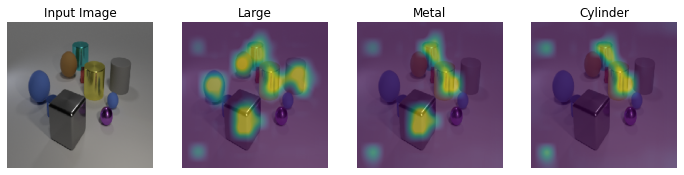

In [66]:
# read in the data

#img = plt.imread(str(Path('data/test_im_000054.png')))
#feat = np.load(Path('data/test_feats_000054.npy'))
img = plt.imread(input_image)
#feat = np.load(Path(os.path.join(data_path,'test_feats_000054.npy')))

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000054).to(device)
print("feat_var.size()", feat_var.size())

#new_features = imresize(feat_var, (1024,14,14))

#import torch.nn as nn
#new_features = nn.Conv2d(512, 1024, kernel_size=1, stride=1, padding=1)

# forward through the network
scene_input = tbd_net.stem(feat_var)

large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
cylinder_filter = forward_input('filter_shape[cylinder]', scene_input, metal_filter)

# display the image and attention masks
fig, axs = plt.subplots(1, 4, figsize=(12,4))
display_helper(axs[0], img, 'Input Image', 0)
display_helper(axs[1], img, 'Input Image', 0)
display_helper(axs[1], attn_tensor_to_np(large_filter), 'Large', alpha=0.5)
display_helper(axs[2], img, 'Input Image', 0)
display_helper(axs[2], attn_tensor_to_np(metal_filter), 'Metal', alpha=0.5)
display_helper(axs[3], img, 'Input Image', 0)
display_helper(axs[3], attn_tensor_to_np(cylinder_filter), 'Cylinder', alpha=0.5)

# compute and print the prediction
count_output = forward_input('count', scene_input, cylinder_filter)
final_output = tbd_net.classifier(count_output)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))

## Figure 3 [Relate Left and Right]
Question : What color is the big object that is left of the large metal sphere and right of the green metal thing?

In [15]:
import argparse, os, json
import h5py
import numpy as np
from scipy.misc import imread, imresize
import torch
import torchvision

def build_model():
  if not hasattr(torchvision.models, 'resnet101'):
    raise ValueError('Invalid model "%s"' % 'resnet101')
  if not 'resnet' in 'resnet101':
    raise ValueError('Feature extraction only supports ResNets')
  cnn = getattr(torchvision.models, 'resnet101')(pretrained=True)
  layers = [
    cnn.conv1,
    cnn.bn1,
    cnn.relu,
    cnn.maxpool,
  ]
  for i in range(3):
    name = 'layer%d' % (i + 1)
    layers.append(getattr(cnn, name))
  model = torch.nn.Sequential(*layers)
  model.cuda()
  model.eval()
  return model

def run_batch(cur_batch, model):
  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image_batch = np.concatenate(cur_batch, 0).astype(np.float32)
  image_batch = (image_batch / 255.0 - mean) / std
  image_batch = torch.FloatTensor(image_batch).cuda()
  image_batch = torch.autograd.Variable(image_batch, volatile=True)

  feats = model(image_batch)
  feats = feats.data.cpu().clone().numpy()

  return feats

input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000012.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000012.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000012 = feats.data.cpu().clone().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:51: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


In [16]:
import torch.nn as nn
# read in the data
#img = plt.imread(str(Path(os.path.join(data_path,'test_im_000012.png'))))
img = plt.imread(input_image)
#feat = np.load(Path(os.path.join(data_path,'test_feats_000012.npy')))
#img = plt.imread(str(Path('data/test_im_000012.png')))
#feat = np.load(Path('data/test_feats_000012.npy'))

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000012).to(device)

# forward through the network
scene_input = tbd_net.stem(feat_var)

#What color is the big object that is left of the large metal sphere and right of the green metal thing?
# forward through the first logical series
large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
sphere_filter = forward_input('filter_shape[sphere]', scene_input, metal_filter)
left_filter, layers_left = forward_input('relate[left]', scene_input, sphere_filter)

# forward through the second logical series
green_filter = forward_input('filter_color[green]', scene_input, tbd_net.ones_var)
metal2_filter = forward_input('filter_material[metal]', scene_input, green_filter)
right_filter, layers_right = forward_input('relate[right]', scene_input, metal2_filter)
#print(right_filter)
# forward through the third logical series
left_filter = left_filter[0][3].unsqueeze(0).unsqueeze(0)
right_filter = right_filter[0][3].unsqueeze(0).unsqueeze(0)
#print("scene_input.size() = ",scene_input.size()) 

#print("left_filter.size() = ",left_filter.size()) 
left_filter[left_filter < 0] = 0
#left_filter =  left_filter+scene_input_trans

right_filter[right_filter < 0] = 0
#right_filter =  right_filter+scene_input_trans

and_filter = forward_input('intersect', left_filter, right_filter)
large2_filter = forward_input('filter_size[large]', scene_input, and_filter)

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax00, img, 'Input Image',alpha=1)
display_helper(ax00, attn_tensor_to_np(large_filter), 'Large', alpha=0.5)
display_helper(ax01, img, 'Input Image',alpha=1)
display_helper(ax01, attn_tensor_to_np(metal_filter), 'Metal',alpha=0.5)
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
#print("sphere_filter att:", sphere_filter)
#print("sphere_filter size:", sphere_filter.size())
#left_filter[left_filter < 0] = 0
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
#print("left_filter att:", left_filter)
#print("sphere_filter size:", left_filter.size())
ax04.remove()

# row 3: second logical series
ax20.remove()
display_helper(ax21, img, 'Input Image',alpha=1)
display_helper(ax21, attn_tensor_to_np(green_filter), 'Green',alpha=0.5)
display_helper(ax22, img, 'Input Image',alpha=1)
display_helper(ax22, attn_tensor_to_np(metal2_filter), 'Metal',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(right_filter), 'Right',alpha=0.5)
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
display_helper(ax13, img, 'Input Image',alpha=1)
display_helper(ax13, attn_tensor_to_np(and_filter), 'And',alpha=0.5)
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(large2_filter), 'Large',alpha=0.5)


fig, (ax00, ax01, ax02, ax03, ax04, ax05) = plt.subplots(1, 6, figsize=(15, 9))

layers_right[0][layers_right[0] < 0.2] = 0
layer0 = layers_right[0][0][3]
#layers[0].unsqueeze(0).unsqueeze(0)
#layers[0][layers[0] > 1] = 1
display_helper(ax00, img, 'Input Image',alpha=1)
display_helper(ax00, attn_tensor_to_np(layer0), 'Relate[Right]:  Layer 1',alpha=0.5)

layers_right[1][layers_right[1] < 0.2] = 0
layer1 = layers_right[1][0][3]
#layers[1].unsqueeze(0).unsqueeze(0)
#layers[1][layers[1] > 1] = 1
display_helper(ax01, img, 'Input Image',alpha=1)
display_helper(ax01, attn_tensor_to_np(layer1), 'Relate[Right]: Layer 2',alpha=0.5)

layers_right[2][layers_right[2] < 0.2] = 0
layer2 = layers_right[2][0][3]
#layers[2].unsqueeze(0).unsqueeze(0)
#layers[2][layers[2] > 1] = 1
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(layer2), 'Relate[Right]: Layer 3',alpha=0.5)

layers_right[3][layers_right[3] < 0.2] = 0
layer3 = layers_right[3][0][3]
#layers[3].unsqueeze(0).unsqueeze(0)
#layers[3][layers[3] > 1] = 1
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(layer3), 'Relate[Right]: Layer 4',alpha=0.5)

layers_right[4][layers_right[4] < 0.2] = 0
layer4 = layers_right[4][0][3]
#layers[4].unsqueeze(0).unsqueeze(0)
#layers[4][layers[4] > 1] = 1
display_helper(ax04, img, 'Input Image',alpha=1)
display_helper(ax04, attn_tensor_to_np(layer4), 'Relate[Right]: Layer 5',alpha=0.5)

layers_right[5][layers_right[5] < 0.2] = 0
layer5 = layers_right[5][0][3]
#layers[5].unsqueeze(0).unsqueeze(0)
#layers[5][layers[5] > 1] = 1
display_helper(ax05, img, 'Input Image',alpha=1)
display_helper(ax05, attn_tensor_to_np(layer5), 'Relate[Right]: Layer 6',alpha=0.5)
#print(layers[5])



fig, (ax00, ax01, ax02, ax03, ax04, ax05) = plt.subplots(1, 6, figsize=(15, 9))

layers_left[0][layers_left[0] < 0.2] = 0
layer0 = layers_left[0][0][3]
#layers[0].unsqueeze(0).unsqueeze(0)
#layers[0][layers[0] > 1] = 1
display_helper(ax00, img, 'Input Image',alpha=1)
display_helper(ax00, attn_tensor_to_np(layer0), 'Relate[Left]:  Layer 1',alpha=0.5)

layers_left[1][layers_left[1] < 0.2] = 0
layer1 = layers_left[1][0][3]
#layers[1].unsqueeze(0).unsqueeze(0)
#layers[1][layers[1] > 1] = 1
display_helper(ax01, img, 'Input Image',alpha=1)
display_helper(ax01, attn_tensor_to_np(layer1), 'Relate[Left]: Layer 2',alpha=0.5)

layers_left[2][layers_left[2] < 0.2] = 0
layer2 = layers_left[2][0][3]
#layers[2].unsqueeze(0).unsqueeze(0)
#layers[2][layers[2] > 1] = 1
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(layer2), 'Relate[Left]: Layer 3',alpha=0.5)

layers_left[3][layers_left[3] < 0.2] = 0
layer3 = layers_left[3][0][3]
#layers[3].unsqueeze(0).unsqueeze(0)
#layers[3][layers[3] > 1] = 1
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(layer3), 'Relate[Left]: Layer 4',alpha=0.5)

layers_left[4][layers_left[4] < 0.2] = 0
layer4 = layers_left[4][0][3]
#layers[4].unsqueeze(0).unsqueeze(0)
#layers[4][layers[4] > 1] = 1
display_helper(ax04, img, 'Input Image',alpha=1)
display_helper(ax04, attn_tensor_to_np(layer4), 'Relate[Left]: Layer 5',alpha=0.5)

layers_left[5][layers_left[5] < 0.2] = 0
layer5 = layers_left[5][0][3]
#layers[5].unsqueeze(0).unsqueeze(0)
#layers[5][layers[5] > 1] = 1
display_helper(ax05, img, 'Input Image',alpha=1)
display_helper(ax05, attn_tensor_to_np(layer5), 'Relate[Left]: Layer 6',alpha=0.5)
#print(layers[5])


# compute and print the prediction
color_output = forward_input('query_color', scene_input, large2_filter)
final_output = tbd_net.classifier(color_output)
_, prediction = final_output.max(1)
print('Prediction (Question: What color is the big object that is left of the large metal sphere and right of the green metal thing?): {}'.format(vocab['answer_idx_to_token'][prediction.item()]))

Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Relate Module
repeat= 128
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
x.size() main torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= tor

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


ValueError: ignored

## Metal filter, Figure 6
No question; this is meant to illustrate that the `Attention` operations behave intuitively

In [69]:
input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000021.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000021.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000021 = feats.data.cpu().clone().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


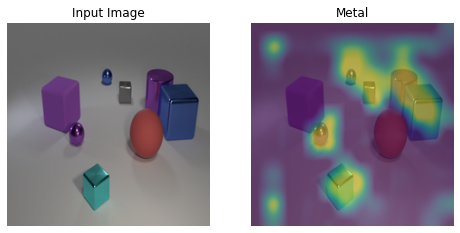

In [70]:
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000012).to(device)
# read in the data
input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000021.png")

output_h5_file = os.path.join(data_path,"test_features_000021.h5")
#img = plt.imread(str(Path('data/test_im_000021.png')))
#feat = np.load(Path('data/test_feats_000021.npy'))

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000021).to(device)

# forward through the network
scene_input = tbd_net.stem(feat_var)
metal_filter = forward_input('filter_material[metal]', scene_input, tbd_net.ones_var)

# display the image and attention mask
fig, axs = plt.subplots(1, 2, figsize=(8,4))
display_helper(axs[0], img, 'Input Image', alpha=1)
display_helper(axs[1], img, 'Input Image', alpha=1)
display_helper(axs[1], attn_tensor_to_np(metal_filter), 'Metal', alpha=0.5)

# Test Image 000000

## Relate [In front] 
Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?

In [11]:
import argparse, os, json
import h5py
import numpy as np
from scipy.misc import imread, imresize
import torch
import torchvision

def build_model():
  if not hasattr(torchvision.models, 'resnet101'):
    raise ValueError('Invalid model "%s"' % 'resnet101')
  if not 'resnet' in 'resnet101':
    raise ValueError('Feature extraction only supports ResNets')
  cnn = getattr(torchvision.models, 'resnet101')(pretrained=True)
  layers = [
    cnn.conv1,
    cnn.bn1,
    cnn.relu,
    cnn.maxpool,
  ]
  for i in range(3):
    name = 'layer%d' % (i + 1)
    layers.append(getattr(cnn, name))
  model = torch.nn.Sequential(*layers)
  model.cuda()
  model.eval()
  return model

def run_batch(cur_batch, model):
  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image_batch = np.concatenate(cur_batch, 0).astype(np.float32)
  image_batch = (image_batch / 255.0 - mean) / std
  image_batch = torch.FloatTensor(image_batch).cuda()
  image_batch = torch.autograd.Variable(image_batch, volatile=True)

  feats = model(image_batch)
  feats = feats.data.cpu().clone().numpy()

  return feats


input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000000.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000000.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000000 = feats.data.cpu().clone().numpy()

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:52: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Relate Module
re

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


Same Module


RuntimeError: ignored

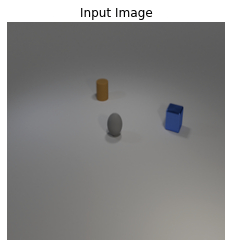

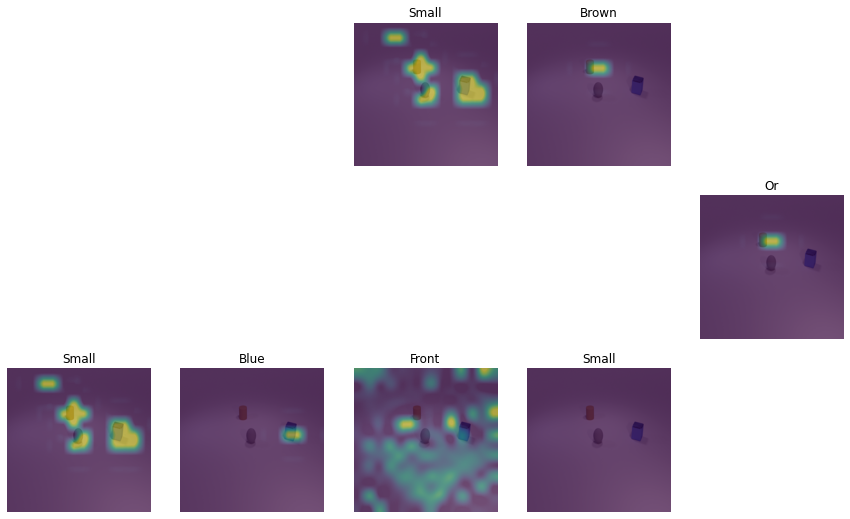

In [14]:
# read in the data
#img = plt.imread(str(Path('data/test_im_000027.png')))
#feat = np.load(Path('data/test_feats_000027.npy'))
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000000).to(device)

#What color is the big object that is left of the large metal sphere and right of the green metal thing?
# forward through the first logical series
#large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
#metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
#sphere_filter = forward_input('filter_shape[sphere]', scene_input, metal_filter)
#left_filter = forward_input('relate[left]', scene_input, sphere_filter)

#Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?
# forward through the network
scene_input = tbd_net.stem(feat_var)

#tiny brown object
small_filter = forward_input('filter_size[small]', scene_input, tbd_net.ones_var)
#apply threshold
small_filter[small_filter < 0.9] = 0
brown_filter = forward_input('filter_color[brown]', scene_input, small_filter)
#apply threshold
brown_filter[brown_filter < 0.9] = 0

#tiny blue object
small_filter2 = forward_input('filter_size[small]', scene_input, tbd_net.ones_var)
#apply threshold
small_filter2[small_filter2 < 0.9] = 0
blue_filter = forward_input('filter_color[blue]', scene_input, small_filter2)
#apply threshold
blue_filter[blue_filter < 0.9] = 0
front_filter = forward_input('relate[front]', scene_input, blue_filter)
#front_filter = front_filter[0][0].unsqueeze(0).unsqueeze(0)
front_filter = front_filter[0][0].unsqueeze(0).unsqueeze(0)
#apply threshold
#front_filter[front_filter < 0.9] = 0

#tiny thing
small_filter3 = forward_input('filter_size[small]', scene_input, front_filter)
#apply threshold
small_filter3[small_filter3 < 0.8] = 0
or_filter = forward_input('union', brown_filter, small_filter3)
#apply threshold
or_filter[or_filter < 0.90] = 0
#tiny thing
or_filter = forward_input('intersect', small_filter, or_filter)
#apply threshold
or_filter[or_filter < 0.8] = 0

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(small_filter), 'Small', alpha=0.5)
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(brown_filter), 'Brown',alpha=0.5)
#display_helper(ax02, img, 'Input Image',alpha=1)
#display_helper(ax02, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
ax00.remove()
ax01.remove()
#print("sphere_filter att:", sphere_filter)
#print("sphere_filter size:", sphere_filter.size())
#left_filter[left_filter < 0] = 0
#display_helper(ax03, img, 'Input Image',alpha=1)
#display_helper(ax03, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
#print("left_filter att:", left_filter)
#print("sphere_filter size:", left_filter.size())
ax04.remove()

# row 3: second logical series
#ax20.remove()
display_helper(ax20, img, 'Input Image',alpha=1)
display_helper(ax20, attn_tensor_to_np(small_filter2), 'Small',alpha=0.5)
display_helper(ax21, img, 'Input Image',alpha=1)
display_helper(ax21, attn_tensor_to_np(blue_filter), 'Blue',alpha=0.5)
display_helper(ax22, img, 'Input Image',alpha=1)
display_helper(ax22, attn_tensor_to_np(front_filter), 'Front',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(small_filter3), 'Small',alpha=0.5)
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
ax13.remove()
#display_helper(ax13, img, 'Input Image',alpha=1)
#display_helper(ax13, attn_tensor_to_np(small_filter3), 'tiny')
#ax14.remove()
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(or_filter), 'Or',alpha=0.5)

#color_output = forward_input('query_color', scene_input, large2_filter)
#final_output = tbd_net.classifier(color_output)

# compute and print the prediction
#same_output = forward_input('same_material', scene_input, small_filter3)
same_output = forward_input('same_material', scene_input, or_filter)
final_output = tbd_net.classifier(same_output)
_, prediction = final_output.max(1)
#Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?

# Test image 000003

## Relate [Right]
There is a big rubber thing; how many small objects are on the right side of it?

In [10]:
input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000003.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000003.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000003 = feats.data.cpu().clone().numpy()

NameError: ignored

In [ ]:

#There is a big rubber thing; how many small objects are on the right side of it?

# read in the data
#img = plt.imread(str(Path('data/test_im_000027.png')))
#feat = np.load(Path('data/test_feats_000027.npy'))
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000003).to(device)

#What color is the big object that is left of the large metal sphere and right of the green metal thing?
# forward through the first logical series
#large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
#metal_filter = forward_input('filter_material[metal]', scene_input, large_filter)
#sphere_filter = forward_input('filter_shape[sphere]', scene_input, metal_filter)
#left_filter = forward_input('relate[left]', scene_input, sphere_filter)

#Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?
# forward through the network
scene_input = tbd_net.stem(feat_var)

#tiny brown object
big_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
big_filter[big_filter < 0.8] = 0
rubber_filter = forward_input('filter_material[rubber]', scene_input, big_filter)
rubber_filter[rubber_filter < 0.8] = 0
right_filter = forward_input('relate[right]', scene_input, rubber_filter)
right_filter = right_filter[0][3].unsqueeze(0).unsqueeze(0)

#apply threshold
right_filter[right_filter < 0.5] = 0

#small object
small_filter = forward_input('filter_size[small]', scene_input, tbd_net.ones_var)
small_filter[small_filter < 0.9] = 0
# Intersection
and_filter = forward_input('intersect', right_filter, small_filter)


# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax01, img, 'Input Image',alpha=1)
display_helper(ax01, attn_tensor_to_np(big_filter), 'Big', alpha=0.5)
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(rubber_filter), 'Rubber', alpha=0.5)
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(right_filter), 'Right',alpha=0.5)
#display_helper(ax02, img, 'Input Image',alpha=1)
#display_helper(ax02, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
ax00.remove()
#ax01.remove()
#print("sphere_filter att:", sphere_filter)
#print("sphere_filter size:", sphere_filter.size())
#left_filter[left_filter < 0] = 0
#display_helper(ax03, img, 'Input Image',alpha=1)
#display_helper(ax03, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
#print("left_filter att:", left_filter)
#print("sphere_filter size:", left_filter.size())
ax04.remove()

# row 3: second logical series
#ax20.remove()
#display_helper(ax20, img, 'Input Image',alpha=1)
#display_helper(ax20, attn_tensor_to_np(small_filter2), 'Small',alpha=0.5)
#display_helper(ax21, img, 'Input Image',alpha=1)
#display_helper(ax21, attn_tensor_to_np(blue_filter), 'Blue',alpha=0.5)
#display_helper(ax22, img, 'Input Image',alpha=1)
#display_helper(ax22, attn_tensor_to_np(front_filter), 'Front',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(small_filter), 'Small',alpha=0.5)

ax20.remove()
ax21.remove()
ax22.remove()
#ax23.remove()
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
ax13.remove()
#display_helper(ax13, img, 'Input Image',alpha=1)
#display_helper(ax13, attn_tensor_to_np(small_filter3), 'tiny')
#ax14.remove()
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(and_filter), 'And',alpha=0.5)

#color_output = forward_input('query_color', scene_input, large2_filter)
#final_output = tbd_net.classifier(color_output)

# compute and print the prediction
#same_output = forward_input('same_material', scene_input, small_filter3)
count = forward_input('count', scene_input, and_filter)
final_output = tbd_net.classifier(count)
_, prediction = final_output.max(1)
#There is a big rubber thing; how many small objects are on the right side of it?

## Relate [Behind]
What number of things are cubes that are behind the cylinder or things behind the sphere?

In [ ]:
#What number of things are cubes that are behind the cylinder or things behind the sphere?

# read in the data
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000003).to(device)

#Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?
# forward through the network
scene_input = tbd_net.stem(feat_var)

#cylinder
cylinder_filter = forward_input('filter_shape[cylinder]', scene_input, tbd_net.ones_var)
cylinder_filter[cylinder_filter < 0.9] = 0
behind_filter, view_layers = forward_input('relate[behind]', scene_input, cylinder_filter)
behind_filter = behind_filter[0][3].unsqueeze(0).unsqueeze(0)
#.visual_encoder[0].att
#trans = tbd_net.function_modules['relate[behind]'].transformer.visual_encoders[0].att
#apply threshold
behind_filter[behind_filter < 0.7] = 0

#sphere
sphere_filter = forward_input('filter_shape[sphere]', scene_input, tbd_net.ones_var)
sphere_filter[sphere_filter < 0.9] = 0
behind_filter2 = forward_input('relate[behind]', scene_input, sphere_filter)
behind_filter2 = behind_filter2[0][3].unsqueeze(0).unsqueeze(0)
#apply threshold
behind_filter2[behind_filter2 < 0.7] = 0

# Intersection
or_filter = forward_input('union', behind_filter, behind_filter2)
or_filter[or_filter < 0.8] = 0
cube_filter = forward_input('filter_shape[cube]', scene_input, or_filter)
cube_filter[cube_filter < 0.8] = 0

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(cylinder_filter), 'Cylinder', alpha=0.5)
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(behind_filter), 'Behind',alpha=0.5)
#display_helper(ax02, img, 'Input Image',alpha=1)
#display_helper(ax02, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
ax00.remove()
ax01.remove()
#print("sphere_filter att:", sphere_filter)
#print("sphere_filter size:", sphere_filter.size())
#left_filter[left_filter < 0] = 0
#display_helper(ax03, img, 'Input Image',alpha=1)
#display_helper(ax03, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
#print("left_filter att:", left_filter)
#print("sphere_filter size:", left_filter.size())
ax04.remove()

# row 3: second logical series
#ax20.remove()
#display_helper(ax20, img, 'Input Image',alpha=1)
#display_helper(ax20, attn_tensor_to_np(small_filter2), 'Small',alpha=0.5)
#display_helper(ax21, img, 'Input Image',alpha=1)
#display_helper(ax21, attn_tensor_to_np(blue_filter), 'Blue',alpha=0.5)
display_helper(ax22, img, 'Input Image',alpha=1)
display_helper(ax22, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(behind_filter2), 'Behind',alpha=0.5)

ax20.remove()
ax21.remove()
#ax22.remove()
#ax23.remove()
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
#ax13.remove()
#display_helper(ax13, img, 'Input Image',alpha=1)
#display_helper(ax13, attn_tensor_to_np(small_filter3), 'tiny')
#ax14.remove()
display_helper(ax13, img, 'Input Image',alpha=1)
display_helper(ax13, attn_tensor_to_np(or_filter), 'Or',alpha=0.5)
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(cube_filter), 'Cube',alpha=0.5)


#color_output = forward_input('query_color', scene_input, large2_filter)
#final_output = tbd_net.classifier(color_output)

# compute and print the prediction
#same_output = forward_input('same_material', scene_input, small_filter3)
count = forward_input('count', scene_input, or_filter)
final_output = tbd_net.classifier(count)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))
#What number of things are cubes that are behind the cylinder or things behind the sphere?

# Transformer Layers

In [ ]:
#What number of things are cubes that are behind the cylinder or things behind the sphere?

# read in the data
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000003).to(device)

#Does the tiny brown object have the same material as the tiny thing that is in front of the tiny blue thing?
# forward through the network
scene_input = tbd_net.stem(feat_var)

#cylinder
cylinder_filter = forward_input('filter_shape[cylinder]', scene_input, tbd_net.ones_var)
cylinder_filter[cylinder_filter < 0.9] = 0
behind_filter, behind_layers = forward_input('relate[behind]', scene_input, cylinder_filter)
behind_filter = behind_filter[0][3].unsqueeze(0).unsqueeze(0)

#apply threshold
behind_filter[behind_filter < 0.7] = 0

#sphere
sphere_filter = forward_input('filter_shape[sphere]', scene_input, tbd_net.ones_var)
sphere_filter[sphere_filter < 0.9] = 0
behind_filter2, layers = forward_input('relate[behind]', scene_input, sphere_filter)
behind_filter2 = behind_filter2[0][3].unsqueeze(0).unsqueeze(0)
#apply threshold
behind_filter2[behind_filter2 < 0.7] = 0

# Intersection
or_filter = forward_input('union', behind_filter, behind_filter2)
or_filter[or_filter < 0.8] = 0
cube_filter = forward_input('filter_shape[cube]', scene_input, or_filter)
cube_filter[cube_filter < 0.8] = 0

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(cylinder_filter), 'Cylinder', alpha=0.5)
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(behind_filter), 'Behind',alpha=0.5)
#display_helper(ax02, img, 'Input Image',alpha=1)
#display_helper(ax02, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
ax00.remove()
ax01.remove()
#print("sphere_filter att:", sphere_filter)
#print("sphere_filter size:", sphere_filter.size())
#left_filter[left_filter < 0] = 0
#display_helper(ax03, img, 'Input Image',alpha=1)
#display_helper(ax03, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
#print("left_filter att:", left_filter)
#print("sphere_filter size:", left_filter.size())
ax04.remove()

# row 3: second logical series
#ax20.remove()
#display_helper(ax20, img, 'Input Image',alpha=1)
#display_helper(ax20, attn_tensor_to_np(small_filter2), 'Small',alpha=0.5)
#display_helper(ax21, img, 'Input Image',alpha=1)
#display_helper(ax21, attn_tensor_to_np(blue_filter), 'Blue',alpha=0.5)
display_helper(ax22, img, 'Input Image',alpha=1)
display_helper(ax22, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(behind_filter2), 'Behind',alpha=0.5)

ax20.remove()
ax21.remove()
#ax22.remove()
#ax23.remove()
ax24.remove()

# row 2: third logical series
ax10.remove()
ax11.remove()
ax12.remove()
#ax13.remove()
#display_helper(ax13, img, 'Input Image',alpha=1)
#display_helper(ax13, attn_tensor_to_np(small_filter3), 'tiny')
#ax14.remove()
display_helper(ax13, img, 'Input Image',alpha=1)
display_helper(ax13, attn_tensor_to_np(or_filter), 'Or',alpha=0.5)
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(cube_filter), 'Cube',alpha=0.5)


fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24)) = plt.subplots(3, 5, figsize=(15, 9))
behind_layers_0 = behind_filter[0].squeeze(0)
print(behind_layers_0.size())
display_helper(ax00, attn_tensor_to_np(behind_layers[0]), 'Layer 0',alpha=1)

#color_output = forward_input('query_color', scene_input, large2_filter)
#final_output = tbd_net.classifier(color_output)

# compute and print the prediction
#same_output = forward_input('same_material', scene_input, small_filter3)
count = forward_input('count', scene_input, or_filter)
final_output = tbd_net.classifier(count)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))
#What number of things are cubes that are behind the cylinder or things behind the sphere?

# Test Image 000025

## Relate [Left]

In [17]:
input_image = os.path.join(dataset_path,"raw/images/test/CLEVR_test_000025.png")
max_images=None
output_h5_file = os.path.join(data_path,"test_features_000025.h5")

model = build_model()

img_size = (224, 224)

with h5py.File(output_h5_file, 'w') as f:
  img = imread(input_image, mode='RGB')
  img = imresize(img, img_size, interp='bicubic')
  img = img.transpose(2, 0, 1)[None]

  mean = np.array([0.485, 0.456, 0.406]).reshape(1, 3, 1, 1)
  std = np.array([0.229, 0.224, 0.224]).reshape(1, 3, 1, 1)

  image = (img / 255.0 - mean) / std
  image = torch.FloatTensor(image).cuda()
  image = torch.autograd.Variable(image, volatile=True)

  feats = model(image)
  feats_000025 = feats.data.cpu().clone().numpy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.


Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Attention module
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
attention repeat= 128
out.size()2= torch.Size([1, 128, 14, 14])
out.size()3= torch.Size([1, 128, 14, 14])
out.size()4= torch.Size([1, 1, 14, 14])
Relate Module
repeat= 128
feats.size()= torch.Size([1, 128, 14, 14])
attn.size()= torch.Size([1, 1, 14, 14])
x.size() main torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= torch.Size([1, 1, 784])
x.size()= tor

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1569: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1558: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.


KeyError: ignored

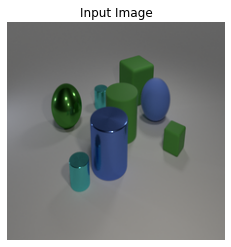

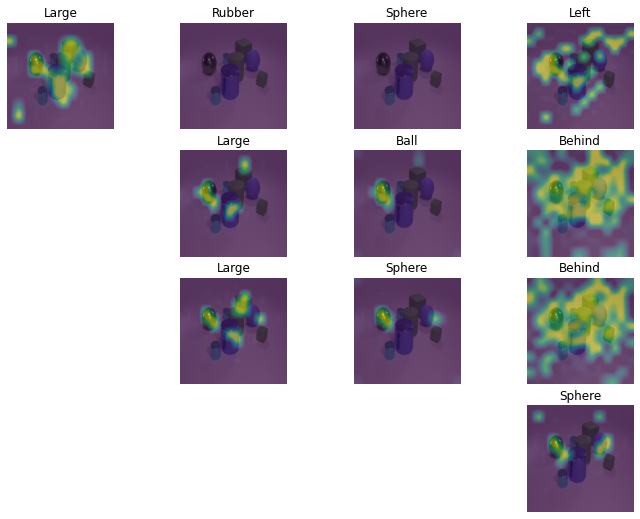

In [25]:
#Is there a matte ball behind the large sphere behind the large ball on the left side of the large rubber sphere?
# read in the data
img = plt.imread(input_image)

# convert to PyTorch tensor
feat_var = torch.FloatTensor(feats_000025).to(device)

# forward through the network
scene_input = tbd_net.stem(feat_var)

#large rubber sphere
large_filter = forward_input('filter_size[large]', scene_input, tbd_net.ones_var)
large_filter[large_filter < 0.2] = 0
rubber_filter = forward_input('filter_material[rubber]', scene_input, large_filter)
rubber_filter[sphere_filter < 0.2] = 0
sphere_filter = forward_input('filter_shape[sphere]', scene_input, rubber_filter)
sphere_filter[sphere_filter < 0.2] = 0
left_filter = forward_input('relate[left]', scene_input, sphere_filter)
left_filter = left_filter[0][3].unsqueeze(0).unsqueeze(0)
#apply threshold
left_filter[left_filter < 0.7] = 0

#large ball
large_filter2 = forward_input('filter_size[large]', scene_input, left_filter)
large_filter2[large_filter2 < 0.6] = 0
ball_filter = forward_input('filter_shape[sphere]', scene_input, large_filter2)
ball_filter[ball_filter < 0.05] = 0
behind_filter = forward_input('relate[behind]', scene_input, ball_filter)
behind_filter = behind_filter[0][3].unsqueeze(0).unsqueeze(0)
#apply threshold
#behind_filter[behind_filter < 0.7] = 0

#large sphere
large_filter3 = forward_input('filter_size[large]', scene_input, behind_filter)
large_filter3[large_filter3 < 0.8] = 0
sphere_filter2 = forward_input('filter_shape[sphere]', scene_input, large_filter3)
sphere_filter2[sphere_filter2 < 0.05] = 0
behind_filter2 = forward_input('relate[behind]', scene_input, sphere_filter2)
behind_filter2 = behind_filter2[0][3].unsqueeze(0).unsqueeze(0)
#apply threshold
#behind_filter2[behind_filter < 0.6] = 0

#matte ball
#matte_filter = forward_input('filter_color[matte]', scene_input, behind_filter2)
#matte_filter[matte_filter < 0.8] = 0
sphere_filter3 = forward_input('filter_shape[sphere]', scene_input, behind_filter2)
sphere_filter3[sphere_filter3 < 0.6] = 0

# display the input image and attention masks
_, ax = plt.subplots()
display_helper(ax, img, 'Input Image',alpha=1)

fig, ((ax00, ax01, ax02, ax03, ax04),
      (ax10, ax11, ax12, ax13, ax14),
      (ax20, ax21, ax22, ax23, ax24),
      (ax30, ax31, ax32, ax33, ax34)) = plt.subplots(4, 5, figsize=(15, 9))

# row 1: first logical series
display_helper(ax01, img, 'Input Image',alpha=1)
display_helper(ax01, attn_tensor_to_np(large_filter), 'Large', alpha=0.5)
display_helper(ax02, img, 'Input Image',alpha=1)
display_helper(ax02, attn_tensor_to_np(rubber_filter), 'Rubber', alpha=0.5)
display_helper(ax03, img, 'Input Image',alpha=1)
display_helper(ax03, attn_tensor_to_np(sphere_filter), 'Sphere',alpha=0.5)
display_helper(ax04, img, 'Input Image',alpha=1)
display_helper(ax04, attn_tensor_to_np(left_filter), 'Left',alpha=0.5)
ax00.remove()

# row 2: second logical series
display_helper(ax12, img, 'Input Image',alpha=1)
display_helper(ax12, attn_tensor_to_np(large_filter2), 'Large',alpha=0.5)
display_helper(ax13, img, 'Input Image',alpha=1)
display_helper(ax13, attn_tensor_to_np(ball_filter), 'Ball',alpha=0.5)
display_helper(ax14, img, 'Input Image',alpha=1)
display_helper(ax14, attn_tensor_to_np(behind_filter), 'Behind',alpha=0.5)
ax10.remove()
ax11.remove()

# row 3: third logical series
ax20.remove()
ax21.remove()
display_helper(ax22, img, 'Input Image',alpha=1)
display_helper(ax22, attn_tensor_to_np(large_filter3), 'Large',alpha=0.5)
display_helper(ax23, img, 'Input Image',alpha=1)
display_helper(ax23, attn_tensor_to_np(sphere_filter2), 'Sphere',alpha=0.5)
display_helper(ax24, img, 'Input Image',alpha=1)
display_helper(ax24, attn_tensor_to_np(behind_filter2), 'Behind',alpha=0.5)


# row 4: fourth logical series
ax30.remove()
ax31.remove()
ax32.remove()
ax33.remove()
display_helper(ax34, img, 'Input Image',alpha=1)
display_helper(ax34, attn_tensor_to_np(sphere_filter3), 'Sphere',alpha=0.5)

# compute and print the prediction
matte = forward_input('query_material[matte]', scene_input, sphere_filter3)
#exist = forward_input('exist', scene_input, matte)
final_output = tbd_net.classifier(matte)
_, prediction = final_output.max(1)
print('Prediction: {}'.format(vocab['answer_idx_to_token'][prediction.item()]))
#Is there a matte ball behind the large sphere behind the large ball on the left side of the large rubber sphere?